In [1]:
from astropy.time import Time
import datetime as dt
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyUserWarning, AstropyWarning
from astropy.table import vstack, Table
import numpy as np
from transit_prediction.utils.list_of_constraints import List_of_constraints 

# Import astroplan tools and constraints
# Other constraints are available
from astroplan import (FixedTarget, Observer, EclipsingSystem,
                       PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint,
                       TimeConstraint, AirmassConstraint, PhaseConstraint)

from masterfile import MasterFile

In [2]:
def min_start_time(constraints_list, obs, target, time, dt=1*u.min):
    
    time = Time(time)
    evening = obs.sun_set_time(time, which='previous')

    time_grid = np.arange(evening.jd, time.jd, dt.to('day').value) * u.d
    time_grid = Time(time_grid, format='jd')
    
    index = is_event_observable(constraints_list,
                                obs, target,
                                times=time_grid).squeeze()

    
    if not index.any():
        raise ValueError('time is out of constraints')
    
    return time_grid[index][0]

def max_end_time(constraints_list, obs, target, time, dt=1*u.min):
    
    time = Time(time)
    morning = obs.sun_rise_time(time, which='next')

    time_grid = np.arange(time.jd, morning.jd, dt.to('day').value) * u.d
    time_grid = Time(time_grid, format='jd')
    
    index = is_event_observable(constraints_list,
                                obs, target,
                                times=time_grid).squeeze()
    
    if not index.any():
        raise ValueError('time is out of constraints')
    
    return time_grid[index][-1]

def min_start_times(constraints_list, obs, target, times, dt=1*u.min):
    
    out = []
    for time in times:
        out.append(min_start_time(constraints_list, obs, target, time, dt=1*u.min))
        
    return Time(out)

def max_end_times(constraints_list, obs, target, times, dt=1*u.min):
    
    out = []
    for time in times:
        out.append(max_end_time(constraints_list, obs, target, time, dt=1*u.min))
        
    return Time(out)

# Get planets info

In [490]:
# target_list = ['WASP-33 b']  
target_list = ["MASCARA-1", "KELT-20", "KELT-9"]
# target_list = ['KELT-7 b', 'WASP-33 b']

In [491]:
data = MasterFile.read().by_plName(*target_list)

# Inputs

In [492]:
t1, t2 = Time(['2019-08-01 00:00', '2020-01-31 00:00'])
site = 'cfht'

# See astroplan available constraints
constraints = [AtNightConstraint.twilight_nautical(),
               AirmassConstraint(max=2.),
               TimeConstraint(t1,t2)
              ]
constraints_list = List_of_constraints(constraints)
supp_cols = ['st_j','st_h','ra','dec','pl_eqt','st_teff']
n_eclipses = 5000

## Special inputs for eclipse

In [493]:
in_eclipse = 0.5  # Relative to eclipse duration
in_eclipse_abs = None #1. * u.h  # Absolute time in eclipse
out_eclipse = 0.5  # Relative to eclipse duration
out_eclipse_abs = None #2* u.h  # Absolute time out of eclipse

# Add info about planets

In [494]:
required_info = data['pl_name','pl_orbper','pl_tranmid','pl_trandur']

In [495]:
data['st_teff']

7554.0
8720.0
10170.0


In [496]:
required_info.show_in_notebook()

idx,pl_name,pl_orbper,pl_tranmid,pl_trandur
,,d,d,d
0,MASCARA-1 b,2.14878,2457097.278,0.16875
1,KELT-20 b,3.4741085,2457503.120049,0.14898
2,KELT-9 b,1.4811235,2457095.68572,0.16316


In [497]:
# Define needed quantities based on planets infos
# Must be quatities arrays (astropy)
# Here we use a given astropy Table (data) to get the infos

epoch, period, transit_duration = data.cols_2_qarr('pl_tranmid','pl_orbper','pl_trandur')
epoch = Time(epoch, format='jd')
pl_name = data['pl_name']


observing_time = t1
obs = Observer.at_site(site)

In [498]:
col_names = ('pl_name',
             'mid_ecl',
             'AM_mid_ecl',
             'tr_start',
             'tr_end',
             'AM_tr_start',
             'AM_tr_end',
             'Obs_start',
             'Baseline_before',
             'Obs_end',
             'Baseline_after',
             't_before_out',
             't_before_in',
             'AM_before_out',
             'AM_before_in',
             't_after_in',
             't_after_out',
             'AM_after_in',
             'AM_after_out',
             'moon',
             *supp_cols
            )
meta = {'Time_limits': [t1, t2],
        'Target_list': pl_name.tolist(),
        'Site': site,
        'in_eclipse': {},
        'out_eclipse': {},
        **constraints_list.show()
       }

In [499]:
from transit_prediction.utils.table_edited import MaskedColumn

In [500]:
full_table = Table()
for itar in range(len(pl_name)):

    # -------------------------
    # Steps to predict transits
    # -------------------------
    try:
        target = FixedTarget.from_name(pl_name[itar])
    except NameResolveError as e:
        print(e)
        try_name = ' '.join(pl_name[itar].split(' ')[:-2])
        print("Trying with {}".format(try_name))
        try:
            target = FixedTarget.from_name(try_name)
        except NameResolveError as e:
            print(e)
            print('Searching in masterfile for RA and dec')
            try_radec = MasterFile.read().by_plName(pl_name[itar])
            ra = try_radec['ra'].quantity
            dec = try_radec['dec'].quantity
            coord = SkyCoord(ra=ra, dec=dec)
            target = FixedTarget(coord=coord,
                                 name=pl_name[itar])
            

    sys = EclipsingSystem(primary_eclipse_time=epoch[itar],
                          orbital_period=period[itar],
                          duration=transit_duration[itar],
                          name=target.name
                         )
            
    if in_eclipse_abs is None:
        in_eclipse_itar = in_eclipse * transit_duration[itar]
    else:
        in_eclipse_itar = out_eclipse_abs
        
    if out_eclipse_abs is None:
        out_eclipse_itar = out_eclipse * transit_duration[itar]
    else:
        out_eclipse_itar = out_eclipse_abs


    t_mid = sys.next_secondary_eclipse_time(observing_time, n_eclipses=n_eclipses)


    
    if t_mid[-1] < t2:
        warnings.warn('end time ('+t2.value +
                      ') is passed the last computed event time (' +
                      t_mid[-1].value+')\n' +
                     '\t You can change the n_eclipse kwarg ' +
                     'value or choose a different window (start or end time)',
                     AstropyUserWarning
                    )

    # You can skip this step by addind a time constraint in the list of constraints
    t_mid = t_mid[t_mid < t2]

    n_event, = t_mid.shape
    
    t1_t4 = sys.next_secondary_ingress_egress_time(observing_time, n_eclipses=n_event)
    range_1 = [(t1_t4[:,0] - out_eclipse_itar).jd,
               (t1_t4[:,0] + in_eclipse_itar).jd]
    range_2 = [(t1_t4[:,1] - in_eclipse_itar).jd,
               (t1_t4[:,1] + out_eclipse_itar).jd]
    range_1 = Time(range_1, format='jd').T
    range_2 = Time(range_2, format='jd').T
    
    index_1 = is_event_observable(constraints_list, obs, target,
                                times_ingress_egress=range_1).squeeze()
    index_2 = is_event_observable(constraints_list, obs, target,
                                times_ingress_egress=range_2).squeeze()


    index = index_1 | index_2

    # -------------------
    # End of steps to predict transits
    # -------------------
    
    # Add infos about requested obs time to meta
    meta['in_eclipse'][sys.name] = in_eclipse_itar.to('min')
    meta['out_eclipse'][sys.name] = out_eclipse_itar.to('min')

    # Put the infos in a table and stack it to the full table
    if index.any():
        name = np.repeat(sys.name,index.sum()).astype(str)
        moon = obs.moon_illumination(t_mid[index])
        AM_mid = obs.altaz(t_mid[index], target).secz
        AM_t1_t4 = obs.altaz(t1_t4[index], target).secz
        AM_1 = obs.altaz(range_1[index], target).secz
        AM_2 = obs.altaz(range_2[index], target).secz
        try:
            obs_start = min_start_times(constraints_list, obs,
                                        target, t1_t4[:,0][index])
            baseline_before = (t1_t4[index][:,0] - obs_start).to('min')
        except ValueError:
            obs_start = min_start_times(constraints_list, obs,
                                        target, t1_t4[:,1][index])
            baseline_before = (t1_t4[index][:,1] - obs_start).to('min')
        
        try:
            obs_end = max_end_times(constraints_list, obs,
                                    target, t1_t4[:,1][index])
            baseline_after = (obs_end - t1_t4[index][:,1]).to('min')
        except ValueError:
            obs_end = max_end_times(constraints_list, obs,
                                    target, t1_t4[:,0][index])
            baseline_after = (obs_end - t1_t4[index][:,0]).to('min')
        mask_1 = [~index_1[index], ~index_1[index]]
        mask_2 = [~index_2[index], ~index_2[index]]
        
        supp = [np.repeat(data[key][itar],index.sum())
                for key in supp_cols]
        cols = [name,
                t_mid[index].iso,
                AM_mid,
                *t1_t4[index].T.iso,
                *AM_t1_t4.T,
                obs_start.iso,
                baseline_before,
                obs_end.iso,
                baseline_after,
                *np.ma.array(range_1[index].T.iso, mask=mask_1),
                *np.ma.array(AM_1.T, mask=mask_1),
                *np.ma.array(range_2[index].T.iso, mask=mask_2),
                *np.ma.array(AM_2.T, mask=mask_2),
                moon,
                *supp
               ]
        table_sys = Table(cols, names=col_names, masked=True)
        full_table = vstack([table_sys, full_table])
    else:
        warnings.warn('No event found for '+sys.name, AstropyUserWarning)

if full_table:
    full_table.sort('mid_ecl')
    full_table.meta = meta
else:
    warnings.warn('No event found at all', AstropyUserWarning)

In [501]:
full_table[full_table['moon']>=0.50]

pl_name,mid_ecl,AM_mid_ecl,tr_start,tr_end,AM_tr_start,AM_tr_end,Obs_start,Baseline_before,Obs_end,Baseline_after,t_before_out,t_before_in,AM_before_out,AM_before_in,t_after_in,t_after_out,AM_after_in,AM_after_out,moon,st_j,st_h,ra,dec,pl_eqt,st_teff
,,,,,,,,min,,min,,,,,,,,,,,,,,,
str11,str23,float64,str23,str23,float64,float64,str23,float64,str23,float64,str23,str23,float64,float64,str23,str23,float64,float64,float64,float64,float64,float32,float32,str4,float64
KELT-9 b,2019-08-09 10:13:59.198,1.0726376877629673,2019-08-09 08:16:30.686,2019-08-09 12:11:27.710,1.1275852250005798,1.2608074747201736,2019-08-09 05:46:07.424,385.33809430897236,2019-08-09 14:10:30.684,353.9999788999558,2019-08-09 06:19:02.174,2019-08-09 10:13:59.198,1.4956811409366848,1.072637687855863,2019-08-09 10:13:59.198,2019-08-09 14:08:56.222,1.072637687855863,1.9786689092437924,0.6789340235060936,7.458,7.492,307.8598,39.93883,4050,10170.0
KELT-20 b,2019-08-11 09:34:01.863,1.041313527267561,2019-08-11 07:46:45.927,2019-08-11 11:21:17.799,1.0463045667473383,1.2573717894901497,2019-08-11 05:43:55.076,337.37871855497355,2019-08-11 13:07:17.799,105.99999368190774,2019-08-11 05:59:29.991,2019-08-11 09:34:01.863,1.2778608122085329,1.0413135274647207,--,--,--,--,0.8479301094634069,7.424,7.446,294.6614,31.21922,2262,8720.0
MASCARA-1 b,2019-08-12 06:55:33.904,1.4909698679305734,2019-08-12 04:54:03.904,2019-08-12 08:57:03.904,4.2769883447365835,1.063763126651261,2019-08-12 06:04:17.545,172.77264699339867,2019-08-12 14:17:03.902,562.999966442585,--,--,--,--,2019-08-12 06:55:33.904,2019-08-12 10:58:33.904,1.490969869001048,1.033558916702105,0.9056761988768773,7.819,7.749,317.55154,10.73887,2570,7554.0
KELT-9 b,2019-08-12 09:19:37.338,1.06658188220926,2019-08-12 07:22:08.826,2019-08-12 11:17:05.850,1.2112028881918633,1.157960938405253,2019-08-12 05:43:17.408,333.8073753565549,2019-08-12 13:58:08.825,395.9999763965607,--,--,--,--,2019-08-12 09:19:37.338,2019-08-12 13:14:34.362,1.0665818821510573,1.605697603631011,0.911355253613195,7.458,7.492,307.8598,39.93883,4050,10170.0
MASCARA-1 b,2019-08-14 10:29:48.496,1.0190851682265933,2019-08-14 08:28:18.496,2019-08-14 12:31:18.496,1.099296106998986,1.2506040654134603,2019-08-14 05:56:59.807,394.3114775419235,2019-08-14 14:09:18.495,340.9999796748162,2019-08-14 06:26:48.496,2019-08-14 10:29:48.496,1.654046880021257,1.0190851684300013,--,--,--,--,0.9890339347706244,7.819,7.749,317.55154,10.73887,2570,7554.0
KELT-9 b,2019-08-15 08:25:15.479,1.0893474984449385,2019-08-15 06:27:46.967,2019-08-15 10:22:43.991,1.3451966281081793,1.0968486124074925,2019-08-15 05:41:19.961,281.40050210058683,2019-08-15 13:46:46.966,438.999973833561,--,--,--,--,2019-08-15 08:25:15.479,2019-08-15 12:20:12.503,1.089347498674583,1.377080075938711,0.9991306145729542,7.458,7.492,307.8598,39.93883,4050,10170.0
KELT-9 b,2019-08-18 07:30:53.620,1.1439322597532413,2019-08-18 05:33:25.108,2019-08-18 09:28:22.132,1.555268025350173,1.0685745179933241,2019-08-18 05:39:15.234,229.11496460437766,2019-08-18 13:34:25.106,480.99997133016586,--,--,--,--,2019-08-18 07:30:53.620,2019-08-18 11:25:50.644,1.143932260007517,1.2315416855145456,0.9299011410241754,7.458,7.492,307.8598,39.93883,4050,10170.0
KELT-20 b,2019-08-18 08:19:27.812,1.0203884852079732,2019-08-18 06:32:11.876,2019-08-18 10:06:43.748,1.112198992668239,1.1273152390205081,2019-08-18 05:39:15.222,267.47542977333063,2019-08-18 12:39:43.747,152.99999088048943,--,--,--,--,2019-08-18 08:19:27.812,2019-08-18 11:53:59.684,1.0203884852117928,1.561636634127781,0.9282713473647541,7.424,7.446,294.6614,31.21922,2262,8720.0


In [391]:
full_table.write('/home/adb/Doctorat/transit_predictions/list_of_eclipses_KELT7.ecsv',
                 delimiter=',')

In [160]:
MasterFile.read().by_plName('209458')

pl_name,ra,st_raerr,st_rah,st_raherr,ra_str,dec,st_decerr,dec_str,st_glon,st_glonerr,st_glat,st_glaterr,st_elon,st_elonerr,st_elat,st_elaterr,st_posn,st_plx,st_plxerr1,st_plxerr2,st_plxlim,st_plxn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_pmra,st_pmraerr,st_pmralim,st_pmdec,st_pmdecerr,st_pmdeclim,st_pm,st_pmerr,st_pmlim,st_pmn,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radvn,st_uj,st_ujerr,st_ujlim,st_bj,st_bjerr,st_bjlim,st_vj,st_vjerr,st_vjlim,st_rc,st_rcerr,st_rclim,st_ic,st_icerr,st_iclim,st_j,st_jerr,st_jlim,st_h,st_herr,st_hlim,st_k,st_kerr,st_klim,st_wise1,st_wise1err,st_wise1lim,st_wise2,st_wise2err,st_wise2lim,st_wise3,st_wise3err,st_wise3lim,st_wise4,st_wise4err,st_wise4lim,st_irac1,st_irac1err,st_irac1lim,st_irac2,st_irac2err,st_irac2lim,st_irac3,st_irac3err,st_irac3lim,st_irac4,st_irac4err,st_irac4lim,st_mips1,st_mips1err,st_mips1lim,st_mips2,st_mips2err,st_mips2lim,st_mips3,st_mips3err,st_mips3lim,st_iras1,st_iras1err,st_iras1lim,st_iras2,st_iras2err,st_iras2lim,st_iras3,st_iras3err,st_iras3lim,st_iras4,st_iras4err,st_iras4lim,st_optmag,st_optmagerr,st_optmaglim,st_optband,st_photn,st_umbj,st_umbjerr,st_umbjlim,st_bmvj,st_bmvjerr,st_bmvjlim,st_vjmic,st_vjmicerr,st_vjmiclim,st_vjmrc,st_vjmrcerr,st_vjmrclim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn,st_spstr,st_ssperr,st_splim,st_spn,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_loggn,st_metfe,st_metfeerr1,st_metfeerr2,st_metfelim,st_metfen,st_metratio,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_lumn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_dens,st_denserr1,st_denserr2,st_denslim,st_densn,st_age,st_ageerr1,st_ageerr2,st_agelim,st_agen,st_vsini,st_vsinierr1,st_vsinierr2,st_vsinilim,st_vsinin,st_acts,st_actserr,st_actslim,st_actsn,st_actr,st_actrerr,st_actrlim,st_actrn,st_actlx,st_actlxerr,st_actlxlim,st_actlxn,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,hd_name,hip_name,2mass_name,swasp_id,pl_hostname,pl_letter,pl_pnum,pl_snum,pl_mnum,pl_status,pl_discmethod,pl_disc,pl_disc_refname,pl_publ_date,pl_facility,pl_telescope,pl_instrument,pl_locale,pl_def_refname,pl_rvflag,pl_imgflag,pl_astflag,pl_tranflag,pl_ttvflag,pl_kepflag,pl_k2flag,pl_nnotes,pl_cbflag,pl_omflag,pl_pelink,pl_edelink,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtpern,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_orblpern,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvampn,pl_conrat,pl_conraterr1,pl_conraterr2,pl_conratlim,pl_conratband,pl_conratn,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim,pl_msinie,pl_msinieerr1,pl_msinieerr2,pl_msinielim,pl_msinin,pl_massj,pl_massjerr1,pl_massjerr2,pl_massjlim,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim,pl_massn,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_rads,pl_radserr1,pl_radserr2,pl_radslim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqtn,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insoln,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandepn,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandurn,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmidn,pl_tsystemref,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_impparn,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdepn,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_

In [389]:
!ls /home/adb/Doctorat/transit_predictions/

list_of_eclipses_GeertJan.ecsv	    list_of_phase_stefan_0.52_0.6.ecsv
list_of_eclipses_mascara-1-2.ecsv   list_of_transits_Boucher.ecsv
list_of_eclipses_WASP33.ecsv	    list_of_transits_mascara-1-2.ecsv
list_of_phase_stefan_0.4_0.48.ecsv


In [388]:
full_table.read('/home/adb/Doctorat/transit_predictions/list_of_eclipses_KELT7.ecsv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/adb/Doctorat/transit_predictions/list_of_eclipses_KELT7.ecsv'

In [38]:
wasp33[wasp33['moon']>=0.50].show_in_notebook()

idx,pl_name,mid_ecl,AM_mid_ecl,tr_start,tr_end,AM_tr_start,AM_tr_end,Obs_start,Baseline_before,Obs_end,Baseline_after,t_before_out,t_before_in,AM_before_out,AM_before_in,t_after_in,t_after_out,AM_after_in,AM_after_out,moon,st_j,st_h
,,,,,,,,,min,,min,,,,,,,,,,,
0,WASP-33 b,2019-08-18 10:48:01.161,1.87238823216738,2019-08-18 09:22:29.001,2019-08-18 12:13:33.321,3.748994356132479,1.322482066540842,2019-08-18 10:37:15.274,96.30077384412297,2019-08-18 15:12:28.999,349.9999791383744,--,--,--,--,2019-08-18 10:48:01.161,2019-08-18 13:39:05.481,1.8723882341281743,1.1083697900489207,0.9231777212180157,7.581,7.516
1,WASP-33 b,2019-09-09 09:47:02.720,1.6485056722255502,2019-09-09 08:21:30.560,2019-09-09 11:12:34.880,2.8645667462234083,1.2363619466876303,2019-09-09 09:10:16.341,122.30899460613728,2019-09-09 15:19:30.559,417.99997508525854,--,--,--,--,2019-09-09 09:47:02.720,2019-09-09 12:38:07.040,1.648505673872442,1.0778833399441008,0.8067609752859747,7.581,7.516
2,WASP-33 b,2019-09-10 15:03:39.474,1.1186331230350584,2019-09-10 13:38:07.314,2019-09-10 16:29:11.634,1.0505567958632867,1.3496349951277935,2019-09-10 09:06:22.547,442.8181124478579,2019-09-10 15:20:07.313,101.99999392032623,2019-09-10 12:12:35.153,2019-09-10 15:03:39.474,1.1028929633549531,1.1186331230964377,--,--,--,--,0.8899012008579541,7.581,7.516
3,WASP-33 b,2019-09-15 12:10:06.487,1.082304167628299,2019-09-15 10:44:34.327,2019-09-15 13:35:38.647,1.2496637803662813,1.0543388929229456,2019-09-15 08:46:50.341,288.80509614944464,2019-09-15 15:21:34.326,276.99998348951345,2019-09-15 09:19:02.167,2019-09-15 12:10:06.487,1.6824459775447866,1.0823041672075682,2019-09-15 12:10:06.487,2019-09-15 15:01:10.807,1.082304167904387,1.1489716373741832,0.9825540410451694,7.581,7.516
4,WASP-33 b,2019-09-20 09:16:33.500,1.5598990299048774,2019-09-20 07:51:01.340,2019-09-20 10:42:05.660,2.5662561787188123,1.2013604956290092,2019-09-20 08:27:15.655,134.83341805636883,2019-09-20 15:22:01.338,450.99997311830526,--,--,--,--,2019-09-20 09:16:33.500,2019-09-20 12:07:37.820,1.559899029257968,1.0670590595042633,0.6772490587263401,7.581,7.516
5,WASP-33 b,2019-09-21 14:33:10.253,1.1405363605741634,2019-09-21 13:07:38.093,2019-09-21 15:58:42.413,1.0529200759470418,1.4062341962810045,2019-09-21 08:23:20.730,455.36138445138937,2019-09-21 15:22:38.093,134.99999195337296,2019-09-21 11:42:05.933,2019-09-21 14:33:10.253,1.0870780914210876,1.1405363612419066,--,--,--,--,0.5548386620166144,7.581,7.516
6,WASP-33 b,2019-10-07 11:09:08.046,1.0614864207249306,2019-10-07 09:43:35.886,2019-10-07 12:34:40.206,1.1810011760969255,1.0687517520623142,2019-10-07 07:20:06.340,314.56443339586264,2019-10-07 15:26:35.885,342.9999795556069,2019-10-07 08:18:03.726,2019-10-07 11:09:08.046,1.5086128150076634,1.0614864204997292,2019-10-07 11:09:08.046,2019-10-07 14:00:12.366,1.0614864209018189,1.2071272693052642,0.6708518711485889,7.581,7.516
7,WASP-33 b,2019-10-12 08:15:35.060,1.416780998402744,2019-10-12 06:50:02.900,2019-10-12 09:41:07.220,2.132173569542084,1.1446753284485744,2019-10-12 07:00:57.736,160.15805505216122,2019-10-12 15:27:02.898,516.9999691843988,--,--,--,--,2019-10-12 08:15:35.060,2019-10-12 11:06:39.380,1.4167809980576098,1.0535934604461077,0.9765914859582057,7.581,7.516
8,WASP-33 b,2019-10-13 13:32:11.813,1.1958225329425318,2019-10-13 12:06:39.653,2019-10-13 14:57:43.973,1.065485288247396,1.5459305706465671,2019-10-13 06:57:09.666,480.5717888474465,2019-10-13 15:27:39.652,200.9999880194664,2019-10-13 10:41:07.493,2019-10-13 13:32:11.813,1.0643009666760415,1.195822533766644,--,--,--,--,0.9971872666367616,7.581,7.516


In [39]:
wasp33.meta

OrderedDict([('Time_limits',
              [<Time object: scale='utc' format='iso' value=2019-08-01 00:00:00.000>,
               <Time object: scale='utc' format='iso' value=2020-01-31 00:00:00.000>]),
             ('Target_list', ['WASP-33 b']),
             ('Site', 'cfht'),
             ('in_eclipse', {'WASP-33 b': <Quantity 85.536 min>}),
             ('out_eclipse', {'WASP-33 b': <Quantity 85.536 min>}),
             ('AtNightConstraint',
              {'force_pressure_zero': True,
               'max_solar_altitude': <Quantity -12. deg>}),
             ('AirmassConstraint',
              {'boolean_constraint': True, 'max': 2.0, 'min': 1}),
             ('TimeConstraint',
              {'max': <Time object: scale='utc' format='iso' value=2020-01-31 00:00:00.000>,
               'min': <Time object: scale='utc' format='iso' value=2019-08-01 00:00:00.000>})])

In [46]:
(85+85)-120

50

In [44]:
MasterFile.read().by_plName('WASP-33')['pl_trandur'].to('h')

<Quantity [2.8512] h>

In [45]:
2.85/2

1.425

In [76]:
semester = Time(np.linspace(t1.jd, t2.jd, 1000), format='jd')

In [94]:
geert = full_table.read('/home/adb/Doctorat/transit_predictions/list_of_eclipses_GeertJan.ecsv')

In [396]:
MasterFile.read().by_plName('KELT-20', 'KELT-9', 'MASCARA-1')['pl_name','st_h','st_teff','2mass_name']

pl_name,st_h,st_teff,2mass_name
,mags,K,
object,float64,float64,str23
KELT-20 b,7.446,8720.0,2MASS J19383872+3113091
KELT-9 b,7.492,10170.0,2MASS J20312634+3956196
MASCARA-1 b,7.749,7554.0,--


In [137]:
geert[geert['moon']>0.5]

pl_name,mid_ecl,AM_mid_ecl,tr_start,tr_end,AM_tr_start,AM_tr_end,Obs_start,Baseline_before,Obs_end,Baseline_after,t_before_out,t_before_in,AM_before_out,AM_before_in,t_after_in,t_after_out,AM_after_in,AM_after_out,moon,st_j,st_h
,,,,,,,,min,,min,,,,,,,,,,,
str11,str23,float64,str23,str23,float64,float64,str23,float64,str23,float64,str23,str23,float64,float64,str23,str23,float64,float64,float64,float64,float64
KELT-9 b,2019-08-09 10:13:59.198,1.0726376877629673,2019-08-09 08:16:30.686,2019-08-09 12:11:27.710,1.1275852250005798,1.2608074747201736,2019-08-09 05:46:07.424,385.33809430897236,2019-08-09 14:10:30.684,353.9999788999558,2019-08-09 06:19:02.174,2019-08-09 10:13:59.198,1.4956811409366848,1.072637687855863,2019-08-09 10:13:59.198,2019-08-09 14:08:56.222,1.072637687855863,1.9786689092437924,0.6789340235060936,7.458,7.492
KELT-20 b,2019-08-11 09:34:01.863,1.041313527267561,2019-08-11 07:46:45.927,2019-08-11 11:21:17.799,1.0463045667473383,1.2573717894901497,2019-08-11 05:43:55.076,337.37871855497355,2019-08-11 13:07:17.799,105.99999368190774,2019-08-11 05:59:29.991,2019-08-11 09:34:01.863,1.2778608122085329,1.0413135274647207,--,--,--,--,0.8479301094634069,7.424,7.446
MASCARA-1 b,2019-08-12 06:55:33.904,1.4909698679305734,2019-08-12 04:54:03.904,2019-08-12 08:57:03.904,4.2769883447365835,1.063763126651261,2019-08-12 06:04:17.545,172.77264699339867,2019-08-12 14:17:03.902,562.999966442585,--,--,--,--,2019-08-12 06:55:33.904,2019-08-12 10:58:33.904,1.490969869001048,1.033558916702105,0.9056761988768773,7.819,7.749
KELT-9 b,2019-08-12 09:19:37.338,1.06658188220926,2019-08-12 07:22:08.826,2019-08-12 11:17:05.850,1.2112028881918633,1.157960938405253,2019-08-12 05:43:17.408,333.8073753565549,2019-08-12 13:58:08.825,395.9999763965607,--,--,--,--,2019-08-12 09:19:37.338,2019-08-12 13:14:34.362,1.0665818821510573,1.605697603631011,0.911355253613195,7.458,7.492
MASCARA-1 b,2019-08-14 10:29:48.496,1.0190851682265933,2019-08-14 08:28:18.496,2019-08-14 12:31:18.496,1.099296106998986,1.2506040654134603,2019-08-14 05:56:59.807,394.3114775419235,2019-08-14 14:09:18.495,340.9999796748162,2019-08-14 06:26:48.496,2019-08-14 10:29:48.496,1.654046880021257,1.0190851684300013,--,--,--,--,0.9890339347706244,7.819,7.749
KELT-9 b,2019-08-15 08:25:15.479,1.0893474984449385,2019-08-15 06:27:46.967,2019-08-15 10:22:43.991,1.3451966281081793,1.0968486124074925,2019-08-15 05:41:19.961,281.40050210058683,2019-08-15 13:46:46.966,438.999973833561,--,--,--,--,2019-08-15 08:25:15.479,2019-08-15 12:20:12.503,1.089347498674583,1.377080075938711,0.9991306145729542,7.458,7.492
KELT-9 b,2019-08-18 07:30:53.620,1.1439322597532413,2019-08-18 05:33:25.108,2019-08-18 09:28:22.132,1.555268025350173,1.0685745179933241,2019-08-18 05:39:15.234,229.11496460437766,2019-08-18 13:34:25.106,480.99997133016586,--,--,--,--,2019-08-18 07:30:53.620,2019-08-18 11:25:50.644,1.143932260007517,1.2315416855145456,0.9299011410241754,7.458,7.492
KELT-20 b,2019-08-18 08:19:27.812,1.0203884852079732,2019-08-18 06:32:11.876,2019-08-18 10:06:43.748,1.112198992668239,1.1273152390205081,2019-08-18 05:39:15.222,267.47542977333063,2019-08-18 12:39:43.747,152.99999088048943,--,--,--,--,2019-08-18 08:19:27.812,2019-08-18 11:53:59.684,1.0203884852117928,1.561636634127781,0.9282713473647541,7.424,7.446


In [507]:
# schedule = geert.copy()
# schedule = wasp33.copy()
schedule = full_table.copy()

In [508]:
mask_bef = schedule['t_before_out'].mask
mask_moon = schedule['moon']<0.5
mask_af = schedule['t_after_out'].mask
mask_full = mask_bef | mask_af

In [519]:
# Save to CFHT form
# table_cfht = schedule["pl_name","ra","dec","t_before_out","t_before_in"][~(mask_bef|mask_moon)]
table_cfht = schedule["pl_name","ra","dec","t_after_in","t_after_out"][~(mask_af|mask_moon)]

# index_pl = table_cfht['pl_name'] == "WASP-33 b"
# table_cfht = table_cfht[index_pl]


In [520]:
# table_cfht.rename_column('t_before_out', 'Date start (UT)')
# table_cfht.rename_column('t_before_in', 'Date end (UT)')
table_cfht.rename_column('t_after_out', 'Date end (UT)')
table_cfht.rename_column('t_after_in', 'Date start (UT)')

In [521]:
table_cfht

pl_name,ra,dec,Date start (UT),Date end (UT)
str11,float32,float32,str23,str23
KELT-9 b,307.8598,39.93883,2019-08-09 10:13:59.198,2019-08-09 14:08:56.222
MASCARA-1 b,317.55154,10.73887,2019-08-12 06:55:33.904,2019-08-12 10:58:33.904
KELT-9 b,307.8598,39.93883,2019-08-12 09:19:37.338,2019-08-12 13:14:34.362
KELT-9 b,307.8598,39.93883,2019-08-15 08:25:15.479,2019-08-15 12:20:12.503
KELT-9 b,307.8598,39.93883,2019-08-18 07:30:53.620,2019-08-18 11:25:50.644
KELT-20 b,294.6614,31.21922,2019-08-18 08:19:27.812,2019-08-18 11:53:59.684
KELT-9 b,307.8598,39.93883,2019-08-21 06:36:31.761,2019-08-21 10:31:28.785
MASCARA-1 b,317.55154,10.73887,2019-09-09 05:20:43.600,2019-09-09 09:23:43.600


In [522]:
table_cfht.write('/home/adb/Doctorat/transit_predictions/CFHT_window_3targets_after.csv',format='ascii',delimiter=',')

In [284]:
before = schedule[~(mask_bef | mask_moon | ~mask_full)]
after = schedule[~(mask_af | mask_moon | ~mask_full)]
full_ecl = schedule[~(mask_full | mask_moon)]

In [285]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colorbar import ColorbarBase 

In [386]:
plt.rc('ytick',labelsize=12)
plt.rc('xtick',labelsize=12)
plt.rc('axes', labelsize=12)

In [280]:
%matplotlib notebook

In [352]:
Time([*before['tr_start'], *after['tr_end'], *full_ecl['mid_ecl']],format='iso').max()

<Time object: scale='utc' format='iso' value=2019-09-21 07:08:13.727>

<IPython.core.display.Javascript object>


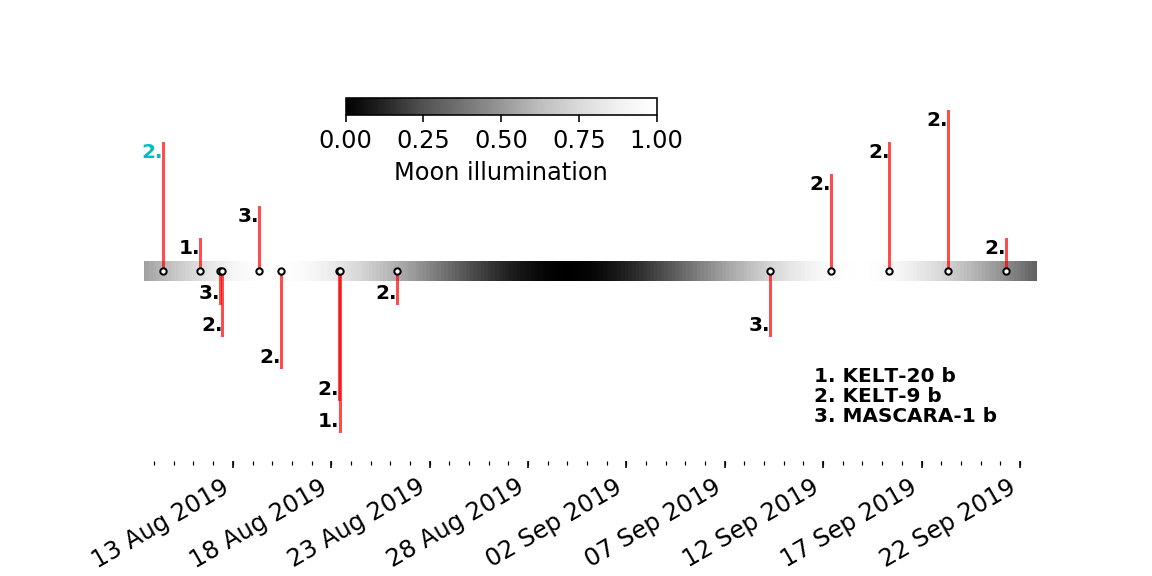

In [387]:
# fig, [ax,axc] = plt.subplots(1,2,figsize=(8,5), gridspec_kw = {'width_ratios':[40, 1]})
fig, ax = plt.subplots(figsize=(8,4))

x, y = semester.datetime, np.zeros(semester.shape)
for i in range(len(x)-1):
    c = moon_cmap[i]
    ax.plot(x[i:i+2], y[i:i+2],linewidth=10,color=(c,c,c))

ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=5))
ax.get_xaxis().set_minor_locator(mdates.DayLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%d %b %Y"))
fig.autofmt_xdate()

# Def labels for names
all_names = np.unique([*before['pl_name'],
                       *after['pl_name'],
                       *full_ecl['pl_name']])


# Iterate through events annotating each one
levels = np.flipud([5,4, 3,2, 1])
for ii, (iname, idate) in enumerate(before['pl_name', 'tr_start']):
    idate = Time(idate).datetime
    iname, = np.where(all_names == iname)
    level = levels[ii % 5]
    vert = 'top'

    ax.scatter(idate, 0, s=10, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(idate, level, "{}.".format(*iname + 1),
            horizontalalignment='right', verticalalignment=vert, fontsize=10,
            weight='bold')
    
for ii, (iname, idate) in enumerate(after['pl_name', 'tr_end']):
    idate = Time(idate).datetime
    iname, = np.where(all_names == iname)
    level = -levels[ii % 5]
    vert = 'bottom'

    ax.scatter(idate, 0, s=10, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(idate, level, "{}.".format(*iname + 1),
            horizontalalignment='right', verticalalignment=vert, fontsize=10,
            weight='bold')
    
for ii, (iname, idate) in enumerate(full_ecl['pl_name', 'mid_ecl']):
    idate = Time(idate).datetime
    iname, = np.where(all_names == iname)
    level = 4
    vert = 'top'

    ax.scatter(idate, 0, s=10, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(idate, level, "{}.".format(*iname + 1), color='c',
            horizontalalignment='right', verticalalignment=vert, fontsize=10,
            weight='bold')

# Ajust axes

all_events = Time([*before['tr_start'], *after['tr_end'], *full_ecl['mid_ecl']],format='iso')
xmax = all_events.max()
xmin = all_events.min()
ax.set_xlim(xmin.datetime,xmax.datetime)
    
# Add colorbar
axc = fig.add_axes([0.3, 0.8,0.27,0.03])
moon_cmap = obs.moon_illumination(semester)
cb1 = ColorbarBase(axc, cmap='Greys_r', orientation='horizontal')
cb1.set_label('Moon illumination')

# Add legend
for ii, inames in enumerate(all_names):
    plt.text(0.75, 0.2 - ii*0.05, '{}. {}'.format(ii+1, inames),
             transform=ax.transAxes, weight='bold')

# Remove components for a cleaner look
plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)
plt.show()

In [287]:
geert.meta

OrderedDict([('Time_limits',
              [<Time object: scale='utc' format='iso' value=2019-08-01 00:00:00.000>,
               <Time object: scale='utc' format='iso' value=2020-01-31 00:00:00.000>]),
             ('Target_list', ['MASCARA-1 b', 'KELT-20 b', 'KELT-9 b']),
             ('Site', 'cfht'),
             ('in_eclipse',
              {'KELT-20 b': <Quantity 107.2656 min>,
               'KELT-9 b': <Quantity 117.4752 min>,
               'MASCARA-1 b': <Quantity 121.5 min>}),
             ('out_eclipse',
              {'KELT-20 b': <Quantity 107.2656 min>,
               'KELT-9 b': <Quantity 117.4752 min>,
               'MASCARA-1 b': <Quantity 121.5 min>}),
             ('AtNightConstraint',
              {'force_pressure_zero': True,
               'max_solar_altitude': <Quantity -12. deg>}),
             ('AirmassConstraint',
              {'boolean_constraint': True, 'max': 2.0, 'min': 1}),
             ('TimeConstraint',
              {'max': <Time object: scale='utc

In [301]:
121.5*2/60

4.05

In [302]:
0.05*60

3.0

In [523]:
MasterFile.read().by_plName('KELT-9','MASCARA-1','KELT-20')['pl_trandur'].to('hour')

<Quantity [3.91584, 4.05   , 3.57552] h>